<!--
---
title: "Regularised Regression. Principle components Regression. Partial Least Squares Regression."
author: "Darya Vanichkina"
questions:
- How do we prevent all variables from being incorporated into a regression model?
objectives:
- To understand additional regression methods that can help us improve our model fit
- To explore PCR and PLSR as ways of dealing with variable multicollinearity
keypoints: 
- There are many extensions to the basic regression approach which can enable a better fit on the data.
- Regularisation helps us improve the performance of regression
- Principle components and partial least squares can help create pseudo-variables which are not correlated
- Advanced methods like MARS can help us extend linear methods to non-linear problems
source: Rmd
teaching: 30
exercises: 15
bibliography: references.bib
---
-->

## Regularised Regression. Principle components Regression. Partial Least Squares Regression.

In [8]:
# when delivering live coding, these libraries have already been loaded

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import statsmodels.api as sm
import seaborn as sns
import pickle
#from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Set up plotting options for seaborn and matplotlib
sns.set_context('notebook') 
sns.set_style('ticks') 
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

# This is also written to generate the lesson notes; not used while live-coding
# load from previous lessons
cached_files = ['models/ames_train_y.pickle','models/ames_test_y.pickle',
                'models/ames_train_X.pickle','models/ames_test_X.pickle',
                'models/predictors.pickle','models/ames_ols_all.pickle']

for file in cached_files:
    with open(file, 'rb') as f:
        objectname = file.replace('models/', '').replace('.pickle', '')
        exec(objectname + " = pickle.load(f)")
        f.close()

In [9]:
# these have not been loaded yet while teaching

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline
from sklearn.utils import resample


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


## A similar function has already been defined, but it's better to re copy paste here
def assess_model_fit(listOfModels,
                     listOfMethodNamesAsStrings, 
                     datasetX, 
                     datasetY):
    columns= ['RMSE', 'R2', 'MAE']
    rows=listOfMethodNamesAsStrings
    results=pd.DataFrame(0.0, columns=columns, index=rows)
    for i, method in enumerate(listOfModels):
        tmp_dataset_X=datasetX
        # while we build the model and predict on the log10Transformed sale price, we display the error in dollars
        # as that makes more sense
        y_pred=10**(method.predict(tmp_dataset_X))
        results.iloc[i,0] = np.sqrt(mean_squared_error(10**(datasetY), y_pred))
        results.iloc[i,1] = r2_score(10**(datasetY), y_pred)
        results.iloc[i,2] = mean_absolute_error(10**(datasetY), y_pred)
    return(results.round(3))

## Hyperparameter tuning: selecting the optimal value of lambda

Recall that both ridge and lasso regression have an additional parameter, lambda, which captures the penalty for incorporating additional features in the model. 


Hence, we need to first find the optimal value of lambda (using cross-validation), and THEN fit the model, and assess its fit.

Also, for both ridge and lasso regression, the SCALE of the variables matters (because the penalty term in the objective function treats all coefficients as comparable!). So we have to use the `StandardScaler()` function to standardize all numeric variables.

We will do all of this in a scikit-learn pipeline:


### Ridge regression (L2 regularisation)

In [10]:
# logspace -  returns numbers spaced evenly on a log scale, base 2, from ^-12 to ^10
# total of 20 of them

alphas = list(np.logspace(-12, 10, 20, base=2))
ames_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', RidgeCV(alphas=alphas, cv=10)),
])


## Toggle comment below to build model
ames_ridge.fit(ames_train_X, ames_train_y)
pickle.dump(ames_ridge, open('models/ames_ridge.pickle', 'wb'))
with open('models/ames_ridge.pickle', 'rb') as f:
    ames_ridge = pickle.load(f)

In [11]:
# what is the best value of alpha (the penalty parameter for Ridge regression?)
best_alpha_ridge = ames_ridge.named_steps.estimator.alpha_
print(best_alpha_ridge)

458.922033222583


In [12]:
# Of the list of elements we tested, which element was it?
alphas.index(best_alpha_ridge)

18

### Lasso regression (L1 regularisation) 

In [13]:
ames_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', LassoCV(alphas=alphas, cv=10)),
])

ames_lasso.fit(ames_train_X, ames_train_y)

## Toggle comment below to build model
ames_lasso.fit(ames_train_X, ames_train_y)
pickle.dump(ames_lasso, open('models/ames_lasso.pickle', 'wb'))
with open('models/ames_lasso.pickle', 'rb') as f:
    ames_lasso = pickle.load(f)
    
    

In [14]:
# what is the best value of alpha (the penalty parameter for Lasso regression?)
best_alpha_lasso = ames_lasso.named_steps.estimator.alpha_
print(best_alpha_lasso)

0.0005447548426570041


In [15]:
# Of the list of elements we tested, which element was it?
alphas.index(best_alpha_lasso)

1

## Elastic net: combining L1 and L2 regularisation

In [16]:
# For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty
# a * L1 + b * L2
# alpha = a + b and l1_ratio = a / (a + b)

parametersGrid = {"alpha": alphas,
                "l1_ratio": np.arange(0.01, 1.0, 0.1)}

ames_enet = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', GridSearchCV(ElasticNet(), parametersGrid, scoring='r2', cv=10)),
])

## Toggle comment below to build model
ames_enet.fit(ames_train_X, ames_train_y)
pickle.dump(ames_enet, open('models/ames_enet.pickle', 'wb'))
with open('models/ames_enet.pickle', 'rb') as f:
    ames_enet = pickle.load(f)

In [17]:
# get the best parameter values 
best_params_enet = ames_enet.named_steps.estimator.best_estimator_

In [18]:
# what is the best value of alpha (the penalty parameter for Lasso regression?)
print(best_params_enet.alpha)

0.06723066163876137


> ## Challenge 1
>
> 1. Look at the coefficients for the model above. What was the balance between L1 (Lasso) and L2 (Ridge) regression?
> 2. What value of alpha was found to be optimal? Was this value expected based on the results we got when we ran Lasso and Ridge independently?
> 
> {: .source}
>
> > ## Solution
> > ~~~ 
> > print(best_params_enet.l1_ratio)
> > 
> > ~~~
> > 2. See [this answer](https://stackoverflow.com/questions/47365978/scikit-learn-elastic-net-approaching-ridge) for an explanation why the 
> >  two values of alpha were not the same.
> > {: .output}
> {: .solution}
{: .challenge}

In [19]:
# What was the RMSE on the training data?
assess_model_fit(listOfModels = [ames_ols_all, ames_ridge, ames_lasso, ames_enet],
                 listOfMethodNamesAsStrings=['OLS','Ridge', 'Lasso', "ENet"], 
                 datasetX=ames_train_X,
                 datasetY=ames_train_y).sort_values("RMSE")

,RMSE,R2,MAE
OLS,18810.886,0.946,11761.208
Lasso,20365.796,0.936,12266.462
ENet,21292.160,0.931,12706.575
Ridge,21330.847,0.930,12951.372


In [20]:
# Compare with the test data!
assess_model_fit(listOfModels = [ames_ols_all, ames_ridge, ames_lasso, ames_enet],
                 listOfMethodNamesAsStrings=['OLS','Ridge', 'Lasso', "ENet"], 
                 datasetX=ames_test_X,
                 datasetY=ames_test_y).sort_values("RMSE")

,RMSE,R2,MAE
Ridge,47670.165,0.623,15758.453
ENet,52482.808,0.543,15590.977
Lasso,59592.173,0.411,15672.588
OLS,64792.914,0.303,16436.269


## Compare the coefficients of each of the linear models:

In [21]:
def plot_coefficients(model, labels):
    coef = model.coef_

    table = pd.Series(coef.ravel(), index = labels).sort_values(ascending=True, inplace=False)
    
    reference = pd.Series(np.abs(coef.ravel()), index = labels).sort_values(ascending=False, inplace=False)
    reference = reference.iloc[:20]
    table = table[reference.index]
    table = table.sort_values(ascending=True, inplace=False)

    fig, ax = fig, ax = plt.subplots()
    table.T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    ax.tick_params(axis=u'y', length=0) 
    ax.set_title('Estimated coefficients (twenty largest in absolute value)', fontsize=14)
    sns.despine()
    return fig, ax

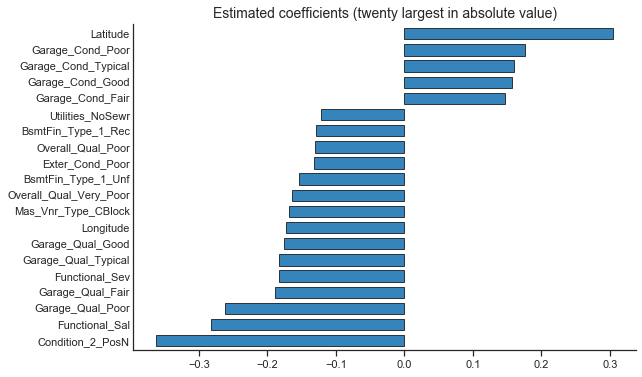

In [22]:
plot_coefficients(ames_ols_all, predictors)# the final_estimator attribute refers to the pipeline
plt.show()

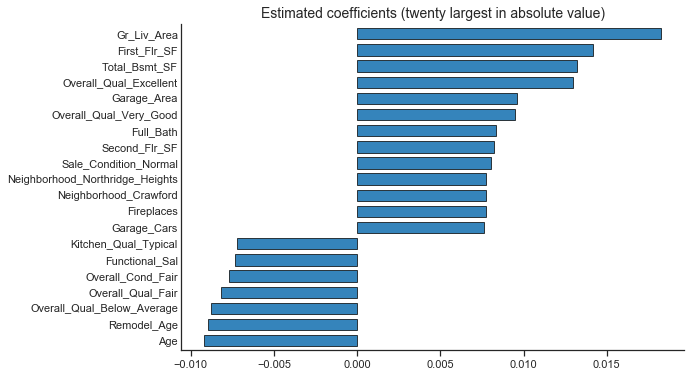

In [23]:
plot_coefficients(ames_ridge._final_estimator, predictors)# the final_estimator attribute refers to the pipeline
plt.show()

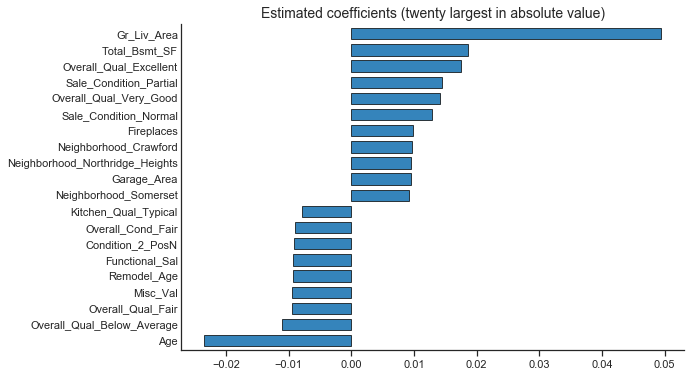

In [24]:
plot_coefficients(ames_lasso._final_estimator, predictors)# the final_estimator attribute refers to the pipeline
plt.show()

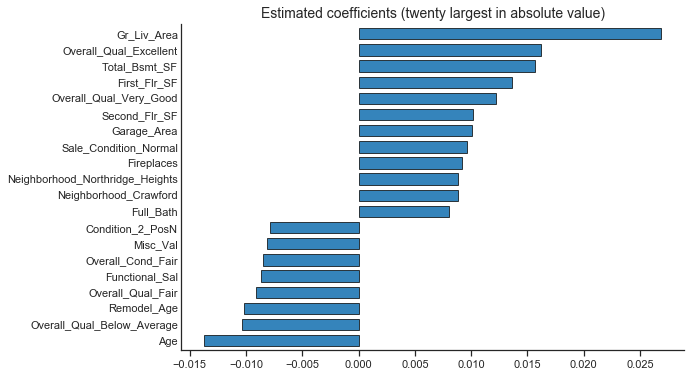

In [25]:
plot_coefficients(ames_enet.named_steps.estimator.best_estimator_, predictors)# the final_estimator attribute refers to the pipeline
plt.show()

> ## Challenge 2
>
> Compare the top coefficients for the models above. Why do you think the top/bottom predictors are different for each one?
> 
> {: .source}
>
> > ## Solution
> > 
> > 
> > {: .output}
> {: .solution}
{: .challenge}

***

## Principle components regression (PCR)

In [26]:
# Define a pipeline to search for the best combination of PCA an
# and linear regression .

linreg = LinearRegression()
pca = PCA()
# how many components?
numcomp = list(np.linspace(1,len(ames_train_X.columns), num = 40).round().astype(int))

pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('pca', pca), 
                       ('linreg', linreg)])
param_grid = {'pca__n_components': numcomp}
ames_pcr = GridSearchCV(pipe, param_grid, iid=False, cv=5,
                      return_train_score=False)



## Toggle comment below to build model
ames_pcr.fit(ames_train_X, ames_train_y)
pickle.dump(ames_pcr, open('models/ames_pcr.pickle', 'wb'))
with open('models/ames_pcr.pickle', 'rb') as f:
    ames_pcr = pickle.load(f)
    
print("Best parameter (CV score=%0.3f):" % ames_pcr.best_score_)
print(ames_pcr.best_params_)

Best parameter (CV score=0.884):
{'pca__n_components': 249}


In [27]:
# How many variables did we have?
print(ames_train_X.shape)
# Which number of PCs did we test?
print(numcomp)

(2051, 286)
[1, 8, 16, 23, 30, 38, 45, 52, 59, 67, 74, 81, 89, 96, 103, 111, 118, 125, 133, 140, 147, 154, 162, 169, 176, 184, 191, 198, 206, 213, 220, 228, 235, 242, 249, 257, 264, 271, 279, 286]


In [28]:
# What was the RMSE on the training data?
assess_model_fit(listOfModels = [ames_ols_all, ames_ridge, ames_lasso, ames_enet, ames_pcr],
                 listOfMethodNamesAsStrings=['OLS','Ridge', 'Lasso', 'ENet', 'PCR'], 
                 datasetX=ames_train_X,
                 datasetY=ames_train_y).sort_values("RMSE")

,RMSE,R2,MAE
OLS,18810.886,0.946,11761.208
PCR,19106.227,0.944,11995.822
Lasso,20365.796,0.936,12266.462
ENet,21292.160,0.931,12706.575
Ridge,21330.847,0.930,12951.372


In [29]:
# What was the RMSE on the training data?
assess_model_fit(listOfModels = [ames_ols_all, ames_ridge, ames_lasso, ames_enet, ames_pcr],
                 listOfMethodNamesAsStrings=['OLS','Ridge', 'Lasso', 'ENet', 'PCR'], 
                 datasetX=ames_test_X,
                 datasetY=ames_test_y).sort_values("RMSE")

,RMSE,R2,MAE
Ridge,47670.165,0.623,15758.453
ENet,52482.808,0.543,15590.977
Lasso,59592.173,0.411,15672.588
PCR,64658.779,0.306,16238.705
OLS,64792.914,0.303,16436.269


> ## Challenge 3
>
> Look at the code above. Is there anything you can do to perhaps slighly improve the fit of the PCR model?
>
> 
> {: .source}
>
> > ## Solution
> > 
> > Test all of the number of principal components from one below the optimum to one right above it. 
> > 
> > {: .output}
> {: .solution}
{: .challenge}

***
## Partial least squares regression (PLSR)

In [30]:
# Define a pipeline to search for the best number of components in PLSR
plsr = PLSRegression()
# how many components?
numcomp = list(np.linspace(1,len(ames_train_X.columns), num = 40).round().astype(int))

pipe = Pipeline(steps=[('scaler', StandardScaler()),
                       ('plsr', plsr)])
param_grid = {'plsr__n_components': numcomp}
ames_plsr = GridSearchCV(pipe, param_grid, iid=False, cv=5,
                      return_train_score=False)


## Toggle comment below to build model
ames_plsr.fit(ames_train_X, ames_train_y)
pickle.dump(ames_plsr, open('models/ames_plsr.pickle', 'wb'))
with open('models/ames_plsr.pickle', 'rb') as f:
    ames_plsr = pickle.load(f)
    


In [31]:
# how many components were best for fitting the model?
ames_plsr.best_params_

{'plsr__n_components': 8}

In [32]:
# What was the RMSE on the training data?
assess_model_fit(listOfModels = [ames_ols_all, ames_ridge, ames_lasso, ames_enet, ames_pcr, ames_plsr],
                 listOfMethodNamesAsStrings=['OLS','Ridge', 'Lasso', 'ENet', 'PCR','PLSR'], 
                 datasetX=ames_train_X,
                 datasetY=ames_train_y).sort_values("RMSE")

,RMSE,R2,MAE
OLS,18810.886,0.946,11761.208
PCR,19106.227,0.944,11995.822
PLSR,20072.891,0.938,12450.140
Lasso,20365.796,0.936,12266.462
ENet,21292.160,0.931,12706.575
Ridge,21330.847,0.930,12951.372


In [33]:
# What was the RMSE on the test data?
assess_model_fit(listOfModels = [ames_ols_all, ames_ridge, ames_lasso, ames_enet, ames_pcr, ames_plsr],
                 listOfMethodNamesAsStrings=['OLS','Ridge', 'Lasso', 'ENet', 'PCR','PLSR'], 
                 datasetX=ames_test_X,
                 datasetY=ames_test_y).sort_values("RMSE")

,RMSE,R2,MAE
Ridge,47670.165,0.623,15758.453
PLSR,51509.933,0.560,15751.082
ENet,52482.808,0.543,15590.977
Lasso,59592.173,0.411,15672.588
PCR,64658.779,0.306,16238.705
OLS,64792.914,0.303,16436.269


In [34]:
import sys
sys.path.insert(0, 'py-earth')
from pyearth import Earth

In [35]:
# Define a pipeline to search for the best number of components in PLSR
mars = Earth()
max_degree = [1,2,3]

pipe = Pipeline(steps=[('scaler', StandardScaler()),
                       ('mars', mars)])
param_grid = {'mars__max_degree': max_degree}
ames_mars = GridSearchCV(pipe, param_grid, iid=False, cv=5,
                      return_train_score=False)


## Toggle comment below to build model
ames_mars.fit(ames_train_X, ames_train_y)
pickle.dump(ames_mars, open('models/ames_mars.pickle', 'wb'))
with open('models/ames_mars.pickle', 'rb') as f:
    ames_mars = pickle.load(f)
    


In [36]:
# What was the RMSE on the training data?
assess_model_fit(listOfModels = [ames_ols_all, ames_ridge, ames_lasso, ames_enet, ames_pcr, ames_plsr, ames_mars],
                 listOfMethodNamesAsStrings=['OLS','Ridge', 'Lasso', 'ENet', 'PCR','PLSR','MARS'], 
                 datasetX=ames_train_X,
                 datasetY=ames_train_y).sort_values("RMSE")

,RMSE,R2,MAE
OLS,18810.886,0.946,11761.208
PCR,19106.227,0.944,11995.822
PLSR,20072.891,0.938,12450.140
Lasso,20365.796,0.936,12266.462
MARS,20980.471,0.933,14240.862
ENet,21292.160,0.931,12706.575
Ridge,21330.847,0.930,12951.372


In [38]:
# What was the RMSE on the test data?
assess_model_fit(listOfModels = [ames_ols_all, ames_ridge, ames_lasso, ames_enet, ames_pcr, ames_plsr, ames_mars],
                 listOfMethodNamesAsStrings=['OLS','Ridge', 'Lasso', 'ENet', 'PCR','PLSR','MARS'], 
                 datasetX=ames_test_X,
                 datasetY=ames_test_y).sort_values("RMSE")

,RMSE,R2,MAE
MARS,24262.447,0.902,15162.366
Ridge,47670.165,0.623,15758.453
PLSR,51509.933,0.560,15751.082
ENet,52482.808,0.543,15590.977
Lasso,59592.173,0.411,15672.588
PCR,64658.779,0.306,16238.705
OLS,64792.914,0.303,16436.269
